# Amazon Book Reviews NLP

### Predicting usefulness and generating justification summary

## 1. Introduction

__Background__

__Problem Statement__

__Hypothesis__

__Data__

__Experimental Approach__

__Notes__

1. Consider using a Colab notebook rather than GCP
    1. Need to request/configure the notebook to use a GPU
    1. Careful they will ask why you're using it if you don't need it
1. Decent resources for sentiment code examples
    1. [Amazon Reviews NLP GitHub](https://github.com/louiefb/amazon-reviews-nlp/blob/master/Amazon%20Reviews%20NLP.ipynbz)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [6]:
! ls

gdrive	sample_data


In [7]:
! ls -l

total 8
drwx------ 6 root root 4096 Mar 15 04:03 gdrive
drwxr-xr-x 1 root root 4096 Mar  9 14:48 sample_data


In [8]:
! mkdir data

In [9]:
ls -l

total 12
drwxr-xr-x 2 root root 4096 Mar 15 04:03 data/
drwx------ 6 root root 4096 Mar 15 04:03 gdrive/
drwxr-xr-x 1 root root 4096 Mar  9 14:48 sample_data/


In [10]:
! cp "/content/gdrive/My Drive/nlp-book-reviews/data/review_samples.csv" .

In [11]:
! mv review_samples.csv data/

In [12]:
! ls

data  gdrive  sample_data


In [18]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [19]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5044114065967959176
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4299577535419097692
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

## 2. Data Exploration

In [3]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
import json
# import pyspark
# from pyspark.sql import SparkSession

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, norm, skew, kurtosis

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# from common import vocabulary

import html
import re
import string
# import spacy
import pickle

import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

from collections import Counter
# from wordcloud import WordCloud
from unicodedata import normalize

import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Dense, LSTM


### 2.1 Load data using PySpark

In [ ]:
spark = SparkSession.builder.appName('Test').getOrCreate()

In [ ]:
mags_meta = spark.read.json('data/magazine_subscriptions_meta.json')
mags = spark.read.json('data/magazine_subscriptions.json')

In [ ]:
books = spark.read.json('data/books.json')
books_meta = spark.read.json('data/books_meta.json')

In [ ]:
mags.printSchema()

In [ ]:
mags_meta.printSchema()

In [ ]:
books_meta.printSchema()

In [ ]:
book_reviews.printSchema()

In [ ]:
books_meta.count()

In [ ]:
books.count()

In [ ]:
mag_categories = mags_meta.groupBy('category')
mag_categories.count().show()

In [ ]:
mags_pd = mags.toPandas()
mags_meta_pd = mags_meta.toPandas()

### 2.2 Load data using pandas

In [ ]:
# Note - runtime is untenable on the books data in local jupyter notebook

# books_meta = pd.read_json('data/books_meta.json', lines=True)
# books = pd.read_json('data/books.json', lines=True)
meta = pd.read_json('data/magazine_subscriptions_meta.json', lines=True)
reviews = pd.read_json('data/magazine_subscriptions.json', lines=True)

In [ ]:
# Drop duplicate records of a unique ASIN
meta.drop_duplicates(subset='asin', inplace=True)

# Drop reviews with no reviewText
reviews = reviews[reviews['reviewText'].isna() == False]

# Convert vote column to numeric
reviews['vote'] = reviews['vote'].str.replace(',', '').fillna(0).astype(int)

In [ ]:
print("\033[1m" + "Dataframe Shape" + "\033[0m")
print(reviews.shape)
print("\n")

print("\033[1m" + "Column Information" + "\033[0m")
reviews.info()
print("\n")

In [ ]:
reviews['reviewText'][1]

In [ ]:
reviews.iloc[0]

In [ ]:
print("\033[1m" + "Dataframe Shape" + "\033[0m")
print(meta.shape)
print("\n")

print("\033[1m" + "Column Information" + "\033[0m")
meta.info()
print("\n")

In [ ]:
meta.iloc[0].category

### 2.3 Meta data transformation

In [ ]:
categories = ['category', 'subcat1', 'subcat2', 'subcat3', 'subcat4']
meta[categories] = pd.DataFrame(meta['category'].to_list())
meta.replace('amp;', '', regex=True, inplace=True)

In [ ]:
meta['category'].value_counts(dropna=False)

In [ ]:
subcat = 'subcat1'
meta[subcat].value_counts(dropna=False)

In [ ]:
meta['brand'].value_counts(dropna=False)

In [ ]:
def count_if(group):
    '''Count the values of a boolean column that are True'''
    return np.sum(group==True)

# Use groupby and agg to summarize relevant statistics from review data by each ASIN
asin_stats = reviews.groupby('asin').agg({'asin': 'count',
                                          'overall': 'mean',
                                          'verified': count_if                                         
                                         })

# Rename columns and reset index
asin_stats.rename(columns={'asin':'reviews',
                           'overall':'avgRating',
                           'verified': 'reviewsVerified'
                          },
                  inplace=True
                 )
asin_stats.reset_index(inplace=True)

# Merge ASIN statistics df with original metadata, drop irrelevant columns
asins = pd.merge(meta,
                asin_stats,
                on='asin',
                how='left'
               )

asins = asins[['asin', 'subcat1', 'brand', 'reviews', 'reviewsVerified', 'avgRating']]
asins['pctVerified'] = asins['reviewsVerified'] / asins['reviews']
asins.head()

In [ ]:
print("\033[1m" + "Column Information" + "\033[0m")
print(asins.describe())

### 2.4 Meta data visualization

In [ ]:
sns.lmplot(x='reviews', y='reviewsVerified', data=asins, hue='subcat1', fit_reg=False)\
   .set(title='Reviews vs. Verified Reviews by SubCategory')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,12))
sns.boxplot(x='avgRating', y='subcat1', orient='h', data=asins)
# sns.swarmplot(x='avgRating', y='subcat1', orient='h', data=asins, color='.1')
plt.show()

### 2.5 Filter and random sampling

In [ ]:
# Filter ASINs to reviews >= 10
asin_samples = asins[asins['reviews'] >= 10]

# Filter ASINs to subcat1 >= 10
# Need to consider whether I want to do this or not
# cat_counts = asin_samples['subcat1'].value_counts(dropna=False)
# asin_samples = asin_samples.loc[asin_samples['subcat1'].isin(cat_counts[cat_counts >= 30].index), :]

asin_samples.shape

In [ ]:
sns.lmplot(x='reviews', y='reviewsVerified', data=asin_samples, hue='subcat1', fit_reg=True)\
   .set(title='Reviews vs. Verified Reviews by SubCategory')

plt.show()

In [ ]:
# Filter reviews based on asin_samples
review_samples = pd.merge(reviews,
                          asin_samples,
                          on='asin',
                          how='inner'
                         )

In [ ]:
# Random sample 5 reviews from each ASIN
# This is likely over-sampling - DON'T USE 
# review_samples = review_samples.groupby('asin').sample(n=5, random_state=1)

In [ ]:
print(reviews.shape)
print(review_samples.shape)

In [ ]:
# Remove outliers greater than 3 std-dev above mean votes for usefulness
# This makes visualization more interpretable, but likely not a good idea for modeling
# Because we want the outliers to be considered the "most useful"

# outlier_threshold = review_samples.describe()['vote']['mean'] +\
#                     (review_samples.describe()['vote']['std'] * 3)

# review_samples = review_samples[review_samples['vote'] <= outlier_threshold]

In [ ]:
# Remove reviews with X votes

min_votes = 10
review_samples = review_samples[review_samples['vote'] >= min_votes]

In [ ]:
print(reviews.shape)
print(review_samples.shape)

In [ ]:
sns.lmplot(x='avgRating', y='vote', data=review_samples, hue='subcat1', fit_reg=True)\
   .set(title='Reviews vs. Verified Reviews by SubCategory')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,12))
sns.boxplot(x='vote', y='subcat1', hue='verified', orient='h', data=review_samples)
# sns.swarmplot(x='vote', y='subcat1', hue='verified', orient='h', data=review_samples)
plt.show()

In [ ]:
sns.histplot(x='vote',
             hue='verified',
             data=review_samples[review_samples['vote'] < 10])
plt.show()

In [ ]:
sns.histplot(x='vote',
             hue='verified',
             data=review_samples[(review_samples['vote'] >= 10) & (review_samples['vote'] < 100)])
plt.show()

In [ ]:
sns.histplot(x='vote',
             hue='verified',
             data=review_samples[review_samples['vote'] >= 100])
plt.show()

In [ ]:
# Explore skew and kurtosis functions in pandas and scipy
pd_skew    = review_samples['vote'].skew()
pd_kurt    = review_samples['vote'].kurt()
sci_skew   = skew(review_samples['vote'], bias=False)
sci_kurt   = kurtosis(review_samples['vote'], bias=False)
sci_skew_b = skew(review_samples['vote'], bias=True)
sci_kurt_b = kurtosis(review_samples['vote'], bias=True)

pd.DataFrame({'skew': [pd_skew, sci_skew, sci_skew_b],
              'kurtosis': [pd_kurt, sci_kurt, sci_kurt_b]},
             index=['pandas', 'scipy-unbiased', 'scipy-biased']
            )

In [ ]:
# Normalize vote variable
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

# Take the log10 of votes
review_samples['vote_norm'] = boxcox(review_samples['vote'], lmbda=0)

# Apply power transformation
pt = PowerTransformer()
review_samples['vote_power'] = pt.fit_transform(pd.DataFrame(review_samples['vote']))

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

sns.histplot(x='vote',
             data=review_samples,
             bins=20,
             ax=ax[0][0]
            )

sns.histplot(x='vote_norm',
             data=review_samples,
             bins=20,
             ax=ax[0][1]
            )

sns.histplot(x='vote_power',
             data=review_samples,
             bins=20,
             ax=ax[1][0]
            )

plt.show()

In [ ]:
# Define the usefulness classification based on vote_power variable

review_samples['useful'] = review_samples['vote_power'].apply(lambda x: 1 if x > 0 else 0)
review_samples['useful'].value_counts()

In [ ]:
review_samples.to_csv('data/review_samples.csv')

## 3. Text pre-processing

In [13]:
review_samples = pd.read_csv('data/review_samples.csv')

In [14]:
# Use html library to decode special characters
html_reviews = review_samples[review_samples['reviewText'].str.contains('&#', na=False)]

if html_reviews.empty:
    # Doesn't appear to be an issue in this data, but will use the else statement to check
    pass
else:
    # Show an example of the unescape function
    sample_review = html_reviews['reviewText'].iloc[0]
    print(sample_review)
    print("")
    decoded_review = html.unescape(sample_review)
    print(decoded_review)

In [15]:
# Remove special characters
pattern = r"\&\#[0-9]+\;"

review_samples["reviewText"] = review_samples["reviewText"].str.replace(pat=pattern, repl="", regex=True)

### 3.1 Lemmatization

In [16]:
# Use lemmatization to reduce words to their root form

# import nltk resources
resources = ["wordnet", "stopwords", "punkt", \
             "averaged_perceptron_tagger", "maxent_treebank_pos_tagger"]

for resource in resources:
    try:
        nltk.data.find("tokenizers/" + resource)
    except LookupError:
        nltk.download(resource, quiet=True)

In [17]:
%%time
# create Lemmatizer object
lemma = WordNetLemmatizer()

def lemmatize_word(tagged_token):
    """ Returns lemmatized word given its tag"""
    root = []
    for token in tagged_token:
        tag = token[1][0]
        word = token[0]
        if tag.startswith('J'):
            root.append(lemma.lemmatize(word, wordnet.ADJ))
        elif tag.startswith('V'):
            root.append(lemma.lemmatize(word, wordnet.VERB))
        elif tag.startswith('N'):
            root.append(lemma.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('R'):
            root.append(lemma.lemmatize(word, wordnet.ADV))
        else:          
            root.append(word)
    return root

def lemmatize_doc(document):
    """ Tags words then returns sentence with lemmatized words"""
    lemmatized_list = []
    tokenized_sent = sent_tokenize(document)
    for sentence in tokenized_sent:
        no_punctuation = re.sub(r"[`'\",.!?()]", " ", sentence)
        tokenized_word = word_tokenize(no_punctuation)
        tagged_token = pos_tag(tokenized_word)
        lemmatized = lemmatize_word(tagged_token)
        lemmatized_list.extend(lemmatized)
    return " ".join(lemmatized_list)

# apply functions to review text
review_samples["reviewProcessed"] = review_samples["reviewText"].apply(lambda row: lemmatize_doc(row))

# Example review
print(review_samples["reviewText"].iloc[1])
print("")
print(review_samples["reviewProcessed"].iloc[1])
print("")

Confirming as of April 2010 - The magazines do NOT come packaged with the software CD's as pictured on the product page, nor does the description disclaim that this is some kind no-CD subscription of the magazine.

The reviews on the ridiculous time frames in which you receive your first issue are, unfortunately, true as well. The description claims 6-10 weeks, but it could take several months longer.

Falsely advertised; buy directly through Maximum PC or a more reliable source where you'll actually get all 12 months with all 12 software discs, rather than 6-10 issues with no discs.

This product is NOT the product described. It's as simple as that.

Confirming as of April 2010 - The magazine do NOT come package with the software CD s as picture on the product page nor do the description disclaim that this be some kind no-CD subscription of the magazine The review on the ridiculous time frame in which you receive your first issue be unfortunately true as well The description claim 6-1

### 3.2 General normalization

In [20]:
# Remove accents

remove_accent = lambda text: normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
review_samples["reviewProcessed"] = review_samples["reviewProcessed"].apply(remove_accent)

# Remove punctuation
pattern = r"[^\w\s]"
review_samples["reviewProcessed"] = review_samples["reviewProcessed"].str.replace(pat=pattern, repl=" ", regex=True)

# Convert to lowercase
review_samples["reviewProcessed"] = review_samples["reviewProcessed"].str.lower()

# Remove stopwords
from nltk.corpus import stopwords

stop_words = stopwords.words("english")
stop_words = [word.replace("\'", "") for word in stop_words]
# print(f"sample stop words: {stop_words[:15]} \n")

remove_stop_words = lambda row: " ".join([token for token in row.split(" ") if token not in stop_words])
review_samples["reviewProcessed"] = review_samples["reviewProcessed"].apply(remove_stop_words)

# Remove extra spaces
pattern = r"[\s]+"
review_samples["reviewProcessed"] = review_samples["reviewProcessed"].str.replace(pat=pattern, repl=" ", regex=True)

# Example review
print(review_samples["reviewText"].iloc[1])
print("")
print(review_samples["reviewProcessed"].iloc[1])

Confirming as of April 2010 - The magazines do NOT come packaged with the software CD's as pictured on the product page, nor does the description disclaim that this is some kind no-CD subscription of the magazine.

The reviews on the ridiculous time frames in which you receive your first issue are, unfortunately, true as well. The description claims 6-10 weeks, but it could take several months longer.

Falsely advertised; buy directly through Maximum PC or a more reliable source where you'll actually get all 12 months with all 12 software discs, rather than 6-10 issues with no discs.

This product is NOT the product described. It's as simple as that.

confirming april 2010 magazine come package software cd picture product page description disclaim kind cd subscription magazine review ridiculous time frame receive first issue unfortunately true well description claim 6 10 week could take several month longer falsely advertise buy directly maximum pc reliable source actually get 12 month

### 3.3 Tokenization and vocabulary

In [21]:
# Create corpora
corpora = review_samples['reviewText'].values
tokenized = [corpus.split(" ") for corpus in corpora]

In [22]:
# Setup phrase modeling
bi_gram = Phrases(tokenized, min_count=300, threshold=50)

tri_gram = Phrases(bi_gram[tokenized], min_count=50, threshold=50)

In [23]:
# Unigrams
uni_gram_tokens = set([token for text in tokenized for token in text])
uni_gram_tokens = set(filter(lambda x: x != "", uni_gram_tokens))

print(list(uni_gram_tokens)[:200])

['"Oct', '"Baby,"', 'bit.', 'race,', 'gladly', 'article!\n\n**Okay,', 'stand', 'mission,', 'Side.', 'Turbo;', 'otherwise.', 'anywhere', 'reaction(s),', 'look!', 'notion', 'shortly,', 'advantage,', 'schedules.', 'solid', 'face,', 'cooker', 'MANCHESTER', 'hotel..no', 'unemotional,', 'procedures.', 'debased', 'all-important', 'systems(!!!);', 'Genesis', 'quarterly,', 'cult,', 'magazine!)', 'is(are)', 'neutral', 'Minidictionary</a>&nbsp;and', 'Expressed', 'maltreating', 'admirer', 'magazines.\n\nIt', 'showing', 'Perfectly', 'Vietnam', 'shown...but', '(Atoosa', 'coach,', 'reconnecting', 'careers,', 'aftermath,', 'filling', 'unashamedly', 'Orchestra', 'egotistical', 'shortcomings.\n\nMarch', 'Duh.', 'emotions.', 'feel.', 'aggression."\n\nAs', 'Reaction"....what?', '41+', 'BR,', 'question/answer', 'mistake.\n\nIts', 'far;', 'service:', 'description', 'that.\nI', 'Tea', 'could,', 'priorities,', 'overboard.\nOn', 'sufficient,', 'feedback.\n\nThe', 'articles.\n-', 'all!\n\nI', 'age-old', 'compri

In [24]:
# Bigrams
bigram_min = bi_gram.min_count
bi_condition = lambda x: x[1] >= bigram_min

bi_gram_tokens = dict(filter(bi_condition, bi_gram.vocab.items()))
bi_gram_tokens = set(bi_gram_tokens)

bi_grams_only = bi_gram_tokens.difference(uni_gram_tokens)
print(list(bi_grams_only))

[b'', b'a_good', b'one', b'_I', b'American', b'were', b'but_I', b"I_don't", b"It's", b'My', b'our', b'about_the', b'my_subscription', b'while', b'a_great', b'few', b'new', b'you', b'version', b'see', b'articles_are', b'with_the', b'now', b'and_I', b'If', b'being', b'would_be', b'both', b'never', b'this', b'can', b'off', b'they_are', b'always', b'subscribe', b'money', b'one_of', b'And', b'each', b'like_the', b'magazine_has', b'them', b'2', b'In', b'there', b'use', b'have_a', b'do', b'issue,', b'would', b'less', b'been', b'of_the', b'as_a', b'enough', b'subscription.', b'well', b'of_my', b'Amazon', b'its', b'to_read', b'the_best', b'there_is', b'get', b'by', b'and_a', b'his', b'this_magazine', b"I've", b'in_my', b'page', b'not', b'with', b'often', b'after', b'through', b'had', b'it.', b'just', b'actually', b'to', b'month', b'look', b'without', b'and', b'have_to', b'on_a', b'is_the', b'digital', b'magazine_that', b'is', b'There', b'There_are', b'before', b'into', b'the_first', b'science',

In [25]:
# Trigrams 
trigram_min = tri_gram.min_count

tri_condition = lambda x: x[1] >= trigram_min

tri_gram_tokens = dict(filter(tri_condition, tri_gram.vocab.items()))
tri_gram_tokens = set(tri_gram_tokens)

tri_grams_only = tri_gram_tokens.difference(bi_gram_tokens)
print(list(tri_grams_only)[:50])

[b'web', b'Every', b'bad', b'stand', b"I_didn't", b'To', b'15', b'reading_this', b'put', b'few_years', b'of_their', b'Even', b'appears', b'that_my', b'out_to', b'open', b"I_won't", b'solid', b'to_keep', b'thought_it', b'content_is', b'appeal_to', b'finally', b'about.', b'is_too', b'LOVE', b'filled', b'piece', b'showing', b'the_rest', b'junk', b'over_a', b'up.', b'for_some', b'about_it', b'monthly', b'is_to', b'and_its', b'On', b'trends', b'will_have', b'more.', b'and_when', b'thinking', b'bother', b'focus', b'of_an', b'whole', b'quality_of', b'make_a']


## 4.0 Model selection

### 4.1 Bi-directional LSTM

In [26]:
max_words = 5000
max_len = 200

reviews = review_samples['reviewText']
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)
reviews = pad_sequences(sequences, maxlen=max_len)

labels = review_samples['useful']
labels = tf.keras.utils.to_categorical(labels, num_classes=2, dtype="float32")

In [27]:
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=0)

In [28]:
# Specify model hyperparameters.
epochs = 5
dropout_rate = 0.7
num_classes = len(np.unique(labels, axis=0))

model = Sequential()
model.add(Embedding(max_words, 40, input_length=max_len))
model.add(Bidirectional(LSTM(20, dropout=dropout_rate)))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=epochs)

Epoch 1/5
134/134 [==============================] - 19s 69ms/step - loss: 0.6883 - accuracy: 0.5482
Epoch 2/5
134/134 [==============================] - 9s 69ms/step - loss: 0.6776 - accuracy: 0.5722
Epoch 3/5
134/134 [==============================] - 9s 70ms/step - loss: 0.6610 - accuracy: 0.6030
Epoch 4/5
134/134 [==============================] - 9s 70ms/step - loss: 0.6279 - accuracy: 0.6562
Epoch 5/5
134/134 [==============================] - 9s 70ms/step - loss: 0.5883 - accuracy: 0.6952


In [29]:
model.evaluate(X_test, y_test, verbose=1)

34/34 [==============================] - 2s 28ms/step - loss: 0.6922 - accuracy: 0.5886


[0.6922044157981873, 0.5886194109916687]

In [30]:
y_true = y_test.argmax(axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

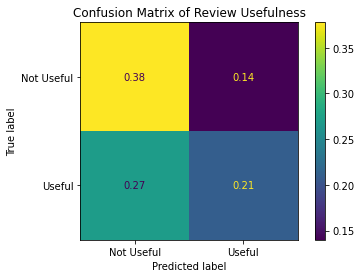

In [33]:
sentiment = ['Not Useful', 'Useful']

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [34]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Not Useful'

In [35]:
sequence = tokenizer.texts_to_sequences(['i really loved how the technician helped me with the issue that i had'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Not Useful'

### 4.X BERT

In [38]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [39]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [40]:
X, y = review_samples['reviewText'], review_samples['useful']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

train = pd.DataFrame([X_train, y_train]).T
dev = pd.DataFrame([X_dev, y_dev]).T
test = pd.DataFrame([X_test, y_test]).T

In [41]:
def convert_data_to_examples(data, DATA_COLUMN, LABEL_COLUMN): 
    examples = data.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                 text_a = x[DATA_COLUMN], 
                                                 text_b = None,
                                                 label = x[LABEL_COLUMN]
                                                ),
                          axis = 1
                         )
  
    return examples


  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(e.text_a,
                                           add_special_tokens=True,
                                           max_length=max_length, # truncates if len(s) > max_length
                                           return_token_type_ids=True,
                                           return_attention_mask=True,
                                           pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
                                           truncation=True
                                          )

        input_ids = input_dict["input_ids"]
        token_type_ids = input_dict["token_type_ids"] 
        attention_mask = input_dict['attention_mask']

        features.append(InputFeatures(input_ids=input_ids,
                                      attention_mask=attention_mask,
                                      token_type_ids=token_type_ids,
                                      label=e.label
                                     )
                       )

    def gen():
        for f in features:
            yield ({"input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                   },
                   f.label,
                  )

    return tf.data.Dataset.from_generator(gen,
                                          ({"input_ids": tf.int32,
                                            "attention_mask": tf.int32,
                                            "token_type_ids": tf.int32
                                           },
                                           tf.int64
                                          ),
                                          ({"input_ids": tf.TensorShape([None]),
                                            "attention_mask": tf.TensorShape([None]),
                                            "token_type_ids": tf.TensorShape([None]),
                                           },
                                           tf.TensorShape([]),
                                          ),
                                         )




In [42]:
DATA_COLUMN = 'reviewText'
LABEL_COLUMN = 'useful'

train_InputExamples = convert_data_to_examples(test, DATA_COLUMN, LABEL_COLUMN)
dev_InputExamples = convert_data_to_examples(test, DATA_COLUMN, LABEL_COLUMN)
test_InputExamples = convert_data_to_examples(test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

dev_data = convert_examples_to_tf_dataset(list(dev_InputExamples), tokenizer)
dev_data = dev_data.batch(32)

test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
test_data = test_data.batch(32)

In [43]:
%%time
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 

              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])
model.fit(train_data, epochs=2, validation_data=dev_data)

Epoch 1/2
68/68 [==============================] - 170s 2s/step - loss: 0.6778 - accuracy: 0.5611 - val_loss: 0.5852 - val_accuracy: 0.7239
Epoch 2/2
68/68 [==============================] - 128s 2s/step - loss: 0.4664 - accuracy: 0.7747 - val_loss: 0.2869 - val_accuracy: 0.8881
CPU times: user 2min 35s, sys: 51.6 s, total: 3min 27s
Wall time: 5min 11s


In [46]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [58]:
# test_sentence = "Golf tips magazine is one of the most aptly titled magazines available today. \
#                  It is chock full of heavily-illustrated exercises and other tips for serious golfers to improve their games.\
#                  \nThere are a number of golf magazines on the newstand today. Most of them rely on a lifestyle format relying \
#                  more heavily on lifestyle-type stories about today's hot golfers and the courses they play. Most of them include \
#                  a brief game tip or two but seem aimed at the casual duffer.\nGolf Tips, on the other hand, features almost nothing \
#                  but heavily illustrated tips on improving one's swing, eliminating mistakes and putting better. It also is heavily \
#                  loaded with features on the latest equipment technology. Each issue also seems to feature an article on the technical \
#                  aspects of a selected major golf course. The articles are written with terminology that serious golfers will understand \
#                  but that may confuse the weekend player. Judging by the amount of advertising in its early issues, this magazine also \
#                  appears to be financially healthy.\nIf a reader wants to read about the PGA Tour's superstars, this magazine is not for \
#                  him/her. But if s/he plans to be one of those superstars, Golf Tips is a good match."

test_sentence = "The information is interesting and fun, the writing is superb, and the writers and editors have a great sense of humor. \
                 I just wish it came out more often!"

predict_input = tokenizer.encode(test_sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf"
                                 )
tf_output = model.predict(predict_input)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = ['Not Useful','Useful'] #(0:Not Useful, 1:Useful)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(labels[label[0]])

Useful


### 4.X Convolutional neural network

In [ ]:
# Specify model hyperparameters
epochs = 5
embed_dim = 5
num_filters = [2, 2, 2]
kernel_sizes = [2, 3, 4]
dense_layer_dims = [10, 4]
dropout_rate = 0.7
num_classes = len(np.unique(labels, axis=0))

# Construct the convolutional neural network.
# The form of each keras layer function is as follows:
#    result = keras.layers.LayerType(arguments for the layer)(layer(s) it should use as input)
# concretely,
#    this_layer_output = keras.layers.Dense(100, activation='relu')(prev_layer_vector)
# performs this_layer_output = relu(prev_layer_vector x W + b) where W has 100 columns.

# Input is a special "layer".  It defines a placeholder that will be overwritten by the training data.
# In our case, we are accepting a list of wordids (padded out to max_len).
wordids = keras.layers.Input(shape=(max_len,))

# Embed the wordids.
# Recall, this is just a mathematically equivalent operation to a linear layer and a one-hot
h = keras.layers.Embedding(ds.vocab.size, embed_dim, input_length=max_len)(wordids)

# Construct "filters" randomly initialized filters with dimension "kernel_size" for each size of filter we want.
# With the default hyperparameters, we construct 2 filters each of size 2, 3, 4.  As in the image above, each filter
# is wide enough to span the whole word embedding (this is why the convolution is "1d" as seen in the
# function name below).
conv_layers_for_all_kernel_sizes = []
for kernel_size, filters in zip(kernel_sizes, num_filters):
    conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
    conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
    conv_layers_for_all_kernel_sizes.append(conv_layer)

# Concat the feature maps from each different size.
h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

# Dropout can help with overfitting (improve generalization) by randomly 0-ing different subsets of values
# in the vector.
# See https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf for details.
h = keras.layers.Dropout(rate=dropout_rate)(h)

### YOUR CODE HERE
# Add a fully connected layer for each dense layer dimension in dense_layer_dims.
### END YOUR CODE

prediction = keras.layers.Dense(num_classes, activation='softmax')(h)

model = keras.Model(inputs=wordids, outputs=prediction)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # From information theory notebooks.
              metrics=['accuracy'])        # What metric to output as we train.